# Studying Tidepool Data

With respect to:
- CGM measurements
- Insulin delivery
- Time zones


In [39]:
import os
import random
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import numpy as np

In [4]:
def load_random_files_from_folder(folder_path, n_files=10, file_extension='.csv'):
    file_names = [f for f in os.listdir(folder_path) if f.endswith(file_extension)]
    selected_files = random.sample(file_names, min(n_files, len(file_names)))

    dataframes = []
    for file in selected_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, low_memory=False)
        df['id'] = file
        dataframes.append(df)
    
    concatenated_df = pd.concat(dataframes, ignore_index=True)
    return concatenated_df

In [5]:
folders = [
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-HCL150-train', 'train-data'),
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-HCL150-test', 'test-data'),
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-SAP100-train', 'train-data'),
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-SAP100-test', 'test-data'),
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-PA50-train', 'train-data'),
    os.path.join('..', 'unprocessed_data', 'Tidepool-JDRF-PA50-test', 'test-data')
]

df = load_random_files_from_folder(folders[0])
print(df.columns)

Index(['activityDuration.units', 'activityDuration.value', 'activityName',
       'deliveryType', 'distance.units', 'distance.value', 'duration',
       'energy.units', 'energy.value', 'est.annotations', 'est.gapSize',
       'est.localTime', 'est.timeProcessing', 'est.timezoneOffset', 'est.type',
       'est.version', 'id', 'normal', 'nutrition.carbohydrate.net',
       'nutrition.carbohydrate.units', 'rate', 'subType', 'time',
       'timezoneOffset', 'type', 'units', 'uploadId', 'value', 'change.agent',
       'change.from', 'change.to', 'deviceId', 'deviceManufacturers',
       'deviceModel', 'deviceSerialNumber', 'deviceTags', 'deviceTime',
       'highAlerts.enabled', 'highAlerts.level', 'highAlerts.snooze',
       'lowAlerts.enabled', 'lowAlerts.level', 'lowAlerts.snooze',
       'outOfRangeAlerts.enabled', 'outOfRangeAlerts.snooze',
       'rateOfChangeAlerts.fallRate.enabled',
       'rateOfChangeAlerts.fallRate.rate',
       'rateOfChangeAlerts.riseRate.enabled',
       'rate

### Profiling the columns found in the data

Each folder has a data-dictionary, but here we will analyze how often each value shows up.

In [7]:
def get_columns_for_files_in_folder(folder_path, file_extension='.csv'):
    file_names = [f for f in os.listdir(folder_path) if f.endswith(file_extension)]
    columns = []
    for file in file_names:
        file_path = os.path.join(folder_path, file)    
        df = pd.read_csv(file_path, low_memory=False)
        columns += df.columns.tolist()
    return columns

In [8]:
# Count the occurrences of each column name
columns_list = [element for folder in folders for element in get_columns_for_files_in_folder(folder)]

In [9]:
string_counts = Counter(columns_list)
df_columns = pd.DataFrame(list(string_counts.items()), columns=['String', 'Count'])
df_columns

,String,Count
0,deliveryType,600
1,duration,600
2,est.annotations,600
3,est.gapSize,600
4,est.localTime,600
...,...,...
88,dose.units,48
89,reportedIntensity,42
90,states,28
91,formulation.simple.actingType,20


Some of the columns are present for all subjects, while a few columns are only present sporadically. It could be useful to use the sporadic columns to validate the insulin using for example insulin on board, basal schedules...

In [ ]:
# Printing the unique values found in a subset of the columns (across several subjects), and the total sum of not nan values

In [10]:
def get_unique_and_not_nan_count_for_columns(folder_path, result, file_extension='.csv'):
    file_names = [f for f in os.listdir(folder_path) if f.endswith(file_extension)]

    for file in file_names:
        file_path = os.path.join(folder_path, file)    
        df = pd.read_csv(file_path, low_memory=False)
        
        for col in df.columns:
            if col not in result:
                result[col] = {
                    'unique_values': set(),  # Use a set to keep unique values
                    'non_nan_sum': 0         # Sum of non-NaN values
                }
            result[col]['unique_values'].update(df[col].dropna().unique())
            result[col]['non_nan_sum'] += df[col].notna().sum()
    return result

In [11]:
result = {}
for folder in folders:
    result = get_unique_and_not_nan_count_for_columns(folder, result)
final_df = pd.DataFrame([
    {'Column': col, 
     'Unique Values': list(data['unique_values']), 
     'Non-NaN Sum': data['non_nan_sum']}
    for col, data in result.items()
])

In [12]:
final_df = final_df.sort_values(by='Non-NaN Sum', ascending=False).reset_index(drop=True)
final_df

,Column,Unique Values,Non-NaN Sum
0,time,"[2019-10-17T19:17:52.000Z, 2018-10-16T21:10:04...",38790716
1,est.localTime,"[2017-06-25T03:36:00, 2019-04-17T18:34:10, 201...",38790716
2,uploadId,"[costik1442702611000, upid_1d980a97485bffd8c0d...",38790716
3,est.version,[0.0.4],38790716
4,id,"[17a4629ac31a9f9aa28a1b03609bc834eba7576, 1159...",38790716
...,...,...,...
88,formulation.simple.actingType,"[long, rapid]",1956
89,bgTarget.range,"[0.8326100000000001, 0.55507]",387
90,reportedIntensity,"[high, medium, low]",86
91,est.timeProcessing,[],0


### Summary of columns interpretations

The following information is common for all of the subjects:

Glucose data:
- Filter data on type 'cbg' and 'smbg'
- Column 'value' holds the glucose values
- 'units' indicates that the unit is consistently in mmol/L, however, 'units.bg' has **one** mg/dL sample

Time zone data:
- 'est.localTime' and 'time' columns are always present
- 'est.timezoneOffset' is the timezone offset from UTC in minutes used by the estimate local time algorithm
- 'time' is UTC timestamp
- 'est.annotations': The annotation label given by the estimate local time algorithm (gap is probably days)
- 'timezoneOffset': Same as 'est.timezoneOffset'?
- 'change.to' and 'change.from' also indicate time shifts. This is sampled 2064 times
- subtype 'timeChange' can indicate time changes
- we have 'change.to' and 'change.from', showing time changes, but only two samples...

Basal data:
- Filter type on 'basal', using 'time' as UTC time, and 'rate' as value, and 'units' as unit
- None of the 150 HCL subjects have 'percent'. In total, 70 000 out of 7.7 million basal rate samples = around 1% of basal samples have it
- Summary of basal-related columns: 
   - percent,The temp basal rate's decimal percentage of the scheduled basal rate,FLOAT,"0.15, 2.5"
   - rate,The set basal rate,FLOAT,"0.2, 1.875"
   - scheduleName,The set basal schedule name,STRING,a553a79b
   - type,The type of data entry ,STRING,"smbg, cbg, bolus, basal, upload"
   - deliveryType,The type of basal event,STRING,"scheduled, temp, suspend"
   - units,The units used for an associated data type,STRING / DICT,"mmol/L, {'bg': 'mg/dL', 'carb': 'grams'}" 
- We have not implemented overrides etc 

Bolus data: 
- As per now, we have simplified:
- filtering on type = 'bolus'
- values are in the 'normal' column
- However, we see that there are 8442 bolus schedules with extended boluses out of 790 000 normal boluses (around 1%)
- Extended boluses are indicated by 'dose.total', 'expectedExtended', 'expectedNormal', 'extended':
   - expectedDuration,"The expected duration (milliseconds) of a suspend, basal, or dual/square bolus",INT,"3600000, 7200000"
   - expectedExtended,The expected delivered amount of extended dual/square bolus insulin,FLOAT,"2.125, 5, 4.696"
   - expectedNormal,The expected delivered amount of normal bolus insulin,FLOAT,"1.5, 2.6, 5.71"
   - extended,The actual delivered amount of extended dual/square bolus insulin,FLOAT,"0.125, 3.15"
   - dose.total is also this
   - bolusSchedules: A dictionary of schedule names and their bolus calculator settings

**QUESTIONS:**
- How do the local time / time / offset columns align? Does it match? (Concat all time-zone related columns and observe)
- What about extended boluses like 'dose.total' compared to 'extended'?

## Basal Rate Analysis

Use a random subset of users as examples. File name as id. 

Questions:
- How does the duration match between each sample? 
- Do we account for overrides? 

In [6]:
df = load_random_files_from_folder(folders[2], n_files=10)

In [7]:
# Print unique basal-related values:
cols = ['id', 'time', 'percent', 'rate', 'type', 'duration', 'deliveryType', 'dose.units', 'subType', 'basalSchedules']
final_df[final_df['Column'].isin(cols)]

NameError: name 'final_df' is not defined

In [8]:
# Fetching basal related files
df = df[[col for col in cols if col in df.columns]]
df['time'] = pd.to_datetime(df['time'])
df

,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules
0,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-03-13 22:52:45+00:00,NaN,NaN,cgmSettings,NaN,NaN,NaN,NaN,NaN
1,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-03-26 05:16:35+00:00,NaN,NaN,cgmSettings,NaN,NaN,NaN,NaN,NaN
2,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-28 05:31:46+00:00,NaN,NaN,pumpSettings,NaN,NaN,NaN,NaN,"{'e79ddb96': [{'rate': 0.3, 'start': 0}, {'rat..."
3,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-29 06:56:56+00:00,NaN,NaN,cgmSettings,NaN,NaN,NaN,NaN,NaN
4,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-29 07:20:12+00:00,NaN,NaN,cgmSettings,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1984041,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-20 23:35:31+00:00,NaN,NaN,cbg,NaN,NaN,NaN,NaN,NaN
1984042,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-20 23:40:31+00:00,NaN,NaN,cbg,NaN,NaN,NaN,NaN,NaN
1984043,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-20 23:45:31+00:00,NaN,NaN,cbg,NaN,NaN,NaN,NaN,NaN
1984044,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-20 23:50:31+00:00,NaN,NaN,cbg,NaN,NaN,NaN,NaN,NaN


In [9]:
# Print row when col is not nan
df[df['percent'].notna()]

,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules
438,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-19 02:57:42+00:00,0.90,0.27,basal,1800000.0,temp,NaN,NaN,NaN
7450,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-05-12 04:45:58+00:00,1.15,1.38,basal,842000.0,temp,NaN,NaN,NaN
7453,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-05-12 05:00:00+00:00,1.15,0.92,basal,2758000.0,temp,NaN,NaN,NaN
7917,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-05-13 14:54:23+00:00,1.50,1.42,basal,3937000.0,temp,NaN,NaN,NaN
7931,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-05-13 16:00:00+00:00,1.50,1.20,basal,1463000.0,temp,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1938905,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-01-11 02:48:49+00:00,0.80,1.00,basal,2155000.0,temp,NaN,NaN,NaN
1941693,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-01-17 23:02:58+00:00,0.80,1.00,basal,2700000.0,temp,NaN,NaN,NaN
1950710,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-02-07 14:07:07+00:00,0.80,1.00,basal,2700000.0,temp,NaN,NaN,NaN
1950713,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-02-07 16:06:24+00:00,0.80,1.00,basal,1498000.0,temp,NaN,NaN,NaN


In [10]:
df[df['percent'].notna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11904 entries, 438 to 1979680
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              11904 non-null  object 
 1   time            11904 non-null  object 
 2   percent         11904 non-null  float64
 3   rate            11904 non-null  float64
 4   type            11904 non-null  object 
 5   duration        11904 non-null  float64
 6   deliveryType    11904 non-null  object 
 7   dose.units      0 non-null      object 
 8   subType         0 non-null      object 
 9   basalSchedules  0 non-null      object 
dtypes: float64(3), object(7)
memory usage: 1023.0+ KB


Rate is never nan when percent is present. Just by observation, it seems like 'rate' is already adjusted by the percent, meaning that rate alone can give a full picture of basal delivery, and percent is not necessary to include. 

Here are some examples:
- When percent is 0.0, rate is also 0.0
- The decimals of the rates when percent is present are often many. For example: Percent 1.1 gives 3.52 U/hr, --> normal rate would be 3,2 U/hr

In [11]:
df[df['deliveryType'] == 'suspend']

,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules
1325,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-22 03:08:57+00:00,NaN,NaN,basal,568000.0,suspend,NaN,NaN,NaN
2155,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-25 01:00:11+00:00,NaN,NaN,basal,63835000.0,suspend,NaN,NaN,NaN
2518,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-26 04:45:17+00:00,NaN,NaN,basal,4901000.0,suspend,NaN,NaN,NaN
3328,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-28 16:58:39+00:00,NaN,NaN,basal,727000.0,suspend,NaN,NaN,NaN
3480,train_e0e0c1b4e8c754ee772f5226162800723cfedd98...,2016-04-29 03:48:29+00:00,NaN,NaN,basal,6031000.0,suspend,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1983161,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-19 03:35:37+00:00,NaN,NaN,basal,25000.0,suspend,NaN,NaN,NaN
1983512,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-19 20:56:28+00:00,NaN,NaN,basal,12000.0,suspend,NaN,NaN,NaN
1983564,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-19 23:46:17+00:00,NaN,NaN,basal,392000.0,suspend,NaN,NaN,NaN
1983917,train_24b7a7a140092b0d2b1c4754efdd06a832493da1...,2019-04-20 15:53:03+00:00,NaN,NaN,basal,165000.0,suspend,NaN,NaN,NaN


¡Important observation! delivery type suspend have rate nan values. Hence, we have to account for that, rate does not reflect suspend in itself. 

In [49]:
# Analyze the rate column and the duration + other columns. We want one where there are suspend delivery types
subject = df['id'].unique()[1]
#df[(df['deliveryType'] == 'suspend') & df[df['id'] == subject]]

In [50]:
# Add a column end-date, and check how it matches. Are there any gaps? 
subject_df = df[df['id'] == subject].copy()
subject_df = subject_df[subject_df['type'] == 'basal']
subject_df['time'] = pd.to_datetime(subject_df['time'])
subject_df['end_date_basal'] = subject_df['time'] + pd.to_timedelta(subject_df['duration'] / 1000, unit='s') # duration originally in ms
subject_df.sort_values(by='time', ascending=False)

# compute time diff between time and end_date_basal with and without suspend
subject_df.head()

,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules,end_date_basal
369475,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 04:00:00+00:00,NaN,0.375,basal,3600000.0,scheduled,NaN,NaN,NaN,2015-09-08 05:00:00+00:00
369489,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 05:00:00+00:00,NaN,0.275,basal,5400000.0,scheduled,NaN,NaN,NaN,2015-09-08 06:30:00+00:00
369508,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 06:30:00+00:00,NaN,0.300,basal,7200000.0,scheduled,NaN,NaN,NaN,2015-09-08 08:30:00+00:00
369533,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 08:30:00+00:00,NaN,0.400,basal,14400000.0,scheduled,NaN,NaN,NaN,2015-09-08 12:30:00+00:00
369586,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 12:30:00+00:00,NaN,0.500,basal,1671000.0,scheduled,NaN,NaN,NaN,2015-09-08 12:57:51+00:00


In [51]:
subject_df[['time', 'end_date_basal', 'rate', 'percent', 'deliveryType']]

,time,end_date_basal,rate,percent,deliveryType
369475,2015-09-08 04:00:00+00:00,2015-09-08 05:00:00+00:00,0.375,NaN,scheduled
369489,2015-09-08 05:00:00+00:00,2015-09-08 06:30:00+00:00,0.275,NaN,scheduled
369508,2015-09-08 06:30:00+00:00,2015-09-08 08:30:00+00:00,0.300,NaN,scheduled
369533,2015-09-08 08:30:00+00:00,2015-09-08 12:30:00+00:00,0.400,NaN,scheduled
369586,2015-09-08 12:30:00+00:00,2015-09-08 12:57:51+00:00,0.500,NaN,scheduled
...,...,...,...,...,...
681256,2018-05-12 07:42:12+00:00,2018-05-12 07:57:12+00:00,0.400,NaN,scheduled
681261,2018-05-12 07:57:12+00:00,2018-05-12 08:32:06+00:00,0.000,0.0,temp
681269,2018-05-12 08:32:06+00:00,2018-05-12 11:32:17+00:00,0.475,NaN,scheduled
681306,2018-05-12 11:32:17+00:00,2018-05-12 22:02:50+00:00,0.500,NaN,scheduled


In [52]:
# add a diff column: 
subject_df['time_diff'] = (subject_df['time'].shift(-1) - subject_df['end_date_basal']).dt.total_seconds()
subject_df[['time', 'end_date_basal', 'rate', 'percent', 'deliveryType', 'time_diff']]

,time,end_date_basal,rate,percent,deliveryType,time_diff
369475,2015-09-08 04:00:00+00:00,2015-09-08 05:00:00+00:00,0.375,NaN,scheduled,0.0
369489,2015-09-08 05:00:00+00:00,2015-09-08 06:30:00+00:00,0.275,NaN,scheduled,0.0
369508,2015-09-08 06:30:00+00:00,2015-09-08 08:30:00+00:00,0.300,NaN,scheduled,0.0
369533,2015-09-08 08:30:00+00:00,2015-09-08 12:30:00+00:00,0.400,NaN,scheduled,0.0
369586,2015-09-08 12:30:00+00:00,2015-09-08 12:57:51+00:00,0.500,NaN,scheduled,0.0
...,...,...,...,...,...,...
681256,2018-05-12 07:42:12+00:00,2018-05-12 07:57:12+00:00,0.400,NaN,scheduled,0.0
681261,2018-05-12 07:57:12+00:00,2018-05-12 08:32:06+00:00,0.000,0.0,temp,0.0
681269,2018-05-12 08:32:06+00:00,2018-05-12 11:32:17+00:00,0.475,NaN,scheduled,0.0
681306,2018-05-12 11:32:17+00:00,2018-05-12 22:02:50+00:00,0.500,NaN,scheduled,0.0


In [53]:
subject_df[subject_df['time_diff'] > 60*5] # Time diff is in seconds

,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules,end_date_basal,time_diff
456746,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2016-06-07 19:37:55+00:00,NaN,0.025,basal,0.0,temp,NaN,NaN,NaN,2016-06-07 19:37:55+00:00,1677.0
596186,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2017-08-29 11:31:13+00:00,NaN,0.500,basal,37727000.0,scheduled,NaN,NaN,NaN,2017-08-29 22:00:00+00:00,879453.0


In [55]:
print(subject_df['time_diff'].max())
print(subject_df['time_diff'].min())
subject_df

879453.0
-22622.0


,id,time,percent,rate,type,duration,deliveryType,dose.units,subType,basalSchedules,end_date_basal,time_diff
369475,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 04:00:00+00:00,NaN,0.375,basal,3600000.0,scheduled,NaN,NaN,NaN,2015-09-08 05:00:00+00:00,0.0
369489,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 05:00:00+00:00,NaN,0.275,basal,5400000.0,scheduled,NaN,NaN,NaN,2015-09-08 06:30:00+00:00,0.0
369508,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 06:30:00+00:00,NaN,0.300,basal,7200000.0,scheduled,NaN,NaN,NaN,2015-09-08 08:30:00+00:00,0.0
369533,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 08:30:00+00:00,NaN,0.400,basal,14400000.0,scheduled,NaN,NaN,NaN,2015-09-08 12:30:00+00:00,0.0
369586,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2015-09-08 12:30:00+00:00,NaN,0.500,basal,1671000.0,scheduled,NaN,NaN,NaN,2015-09-08 12:57:51+00:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
681256,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2018-05-12 07:42:12+00:00,NaN,0.400,basal,900000.0,scheduled,NaN,NaN,NaN,2018-05-12 07:57:12+00:00,0.0
681261,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2018-05-12 07:57:12+00:00,0.0,0.000,basal,2094000.0,temp,NaN,NaN,NaN,2018-05-12 08:32:06+00:00,0.0
681269,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2018-05-12 08:32:06+00:00,NaN,0.475,basal,10811000.0,scheduled,NaN,NaN,NaN,2018-05-12 11:32:17+00:00,0.0
681306,train_fa6d14d94cca2cb2c33b9acd791a8fdbbc174c58...,2018-05-12 11:32:17+00:00,NaN,0.500,basal,37833000.0,scheduled,NaN,NaN,NaN,2018-05-12 22:02:50+00:00,0.0


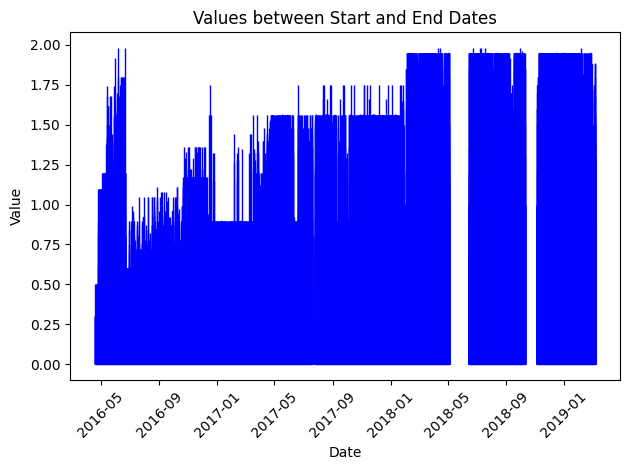

In [46]:
# Plot basals for subject
fig, ax = plt.subplots()

for _, row in subject_df.iterrows():
    # Plotting a line between start_date and end_date with the corresponding value
    ax.fill_between([row['time'], row['end_date_basal']], [row['rate'], row['rate']], color='blue')

# Format the plot
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Values between Start and End Dates')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Conclusion: We can see that there is some missing data, and these should be filled with nan values. 

In [70]:
# Create a function that results for each subject id a dataframe with min diff, max diff, total hours diff
# MAKE SURE ITS SORTED!
# Iterate over all subjects to check that rate and duration makes sense
# Can min diff be negative? how do we handle such overlaps? 
# We should print total hours of missing basals, along with missing cgmvalues
def get_duration_stats(df):
    subject_ids = df['id'].unique()
    count = 1
    for subject_id in subject_ids:
        subset_df = df[df['id'] == subject_id]
        subset_df = subset_df[subset_df['type'] == 'basal']
        subset_df['time'] = pd.to_datetime(subset_df['time'])
        subset_df['end_date_basal'] = subset_df['time'] + pd.to_timedelta(subset_df['duration'] / 1000, unit='s') # duration originally in ms
        subset_df.sort_values(by='time', ascending=False)
        subset_df['time_diff'] = (subset_df['time'].shift(-1) - subset_df['end_date_basal']).dt.total_seconds()
        
        max_val = subset_df["time_diff"].max()
        min_val = subset_df["time_diff"].min()
        total_diff_hours = subset_df["time_diff"].sum() / 60 / 60
        total_basal_hours = subset_df["duration"].sum() / 1000 / 60 / 60
        percent = total_diff_hours / total_basal_hours * 100
        print(f'{count}: Max {max_val}, Min {min_val}, Total Diff Hours {total_diff_hours:.1f}, Total Basal Hours {total_basal_hours:.1f}, Missing data percent {percent:.1f}%')
        count += 1 


In [71]:
# NOTE: Some of the stats dont make sense for negative diff values
get_duration_stats(df)

1: Max 3646261.0, Min 0.0, Total Diff Hours 1792.0, Total Basal Hours 23457.2, Missing data percent 7.6%
2: Max 879453.0, Min -22622.0, Total Diff Hours 236.9, Total Basal Hours 23232.2, Missing data percent 1.0%
3: Max 6740.0, Min 0.0, Total Diff Hours 2.6, Total Basal Hours 8211.0, Missing data percent 0.0%
4: Max 302.0, Min 0.0, Total Diff Hours 0.6, Total Basal Hours 8690.6, Missing data percent 0.0%
5: Max 2538990.0, Min 0.0, Total Diff Hours 787.4, Total Basal Hours 23429.8, Missing data percent 3.4%
6: Max 33192.0, Min 0.0, Total Diff Hours 9.2, Total Basal Hours 21917.3, Missing data percent 0.0%
7: Max 2674.0, Min -431606.0, Total Diff Hours -290.8, Total Basal Hours 7635.8, Missing data percent -3.8%
8: Max 0.0, Min -18000.0, Total Diff Hours -56.8, Total Basal Hours 9190.3, Missing data percent -0.6%
9: Max 36910.0, Min 0.0, Total Diff Hours 10.3, Total Basal Hours 11772.9, Missing data percent 0.1%
10: Max 0.0, Min 0.0, Total Diff Hours 0.0, Total Basal Hours 7725.5, Missin

In [ ]:
# TODO: WE HAVE TO UNDERSTAND WHY SOME TIME DIFFS ARE NEGATIVE, AND HOW TO HANDLE THEM!
# TODO: WE HAVE TO UNDERSTAND IF THE OTHER TIME GAPS CORRESPOND TO TIME GAPS IN CGM VALUES AND GENERAL DATA

## Time Zone Analysis

- How does the local time / time / offsets align? 
- For a random subset of n subjects, plot the 24-hour profile of local time versus UTC time (in same plot!)

## Bolus Analysis

- How are boluses looking? 